# Goal: Locate multiple spot in an image

In [17]:
import numpy as np
from scipy import optimize
from matplotlib.ticker import NullFormatter

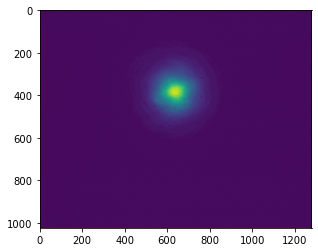

In [12]:
data=np.loadtxt('real_data.txt')
plt.imshow(data)

## Traditional Solution:
    -- Integrate image in x and y direction
    -- Fit gaussian model on each direction and find the peak

In [23]:
def gaussian(x, amplitude, mean, stddev,constant):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)+constant

def traditional(data):

    ximg = np.sum(data,axis=0)
    yimg = np.sum(data,axis=1)

    datax = ximg
    x = np.arange(0,len(ximg))
    poptx, _ = optimize.curve_fit(gaussian, x, datax)

    datay = yimg
    y = np.arange(0,len(yimg))
    popty, _ = optimize.curve_fit(gaussian, y, datay)

    centerx = poptx[1]
    centery = popty[1]
    errx = poptx[2]
    erry = popty[2]

    # start with a rectangular Figure

    plt.figure(1, figsize=(8, 8))

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.52
    bottom_h = height + 0.02 + 0.1
    left_h = left + width + 0.02
    nullfmt = NullFormatter()

    rect_img = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    aximg = plt.axes(rect_img)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    aximg.imshow(data)
    aximg.set_xticks([0,400,800,1200])
    aximg.set_xticklabels([0,400,800,1200], fontsize=20) 
    aximg.set_yticks([0,300,600,900])
    aximg.set_yticklabels([0,300,600,900], fontsize=20) 
    aximg.errorbar(centerx,centery,errx,erry,color='r')
    aximg.set_xlabel('x',fontsize=30)
    aximg.set_ylabel('y',fontsize=30)

    axHistx.plot(ximg)
    axHistx.plot(x, gaussian(x, *poptx))
    axHistx.set_xticks([])
    axHistx.set_yticks([])
    axHisty.plot(yimg,np.arange(1024,0,-1))
    axHisty.plot(gaussian(y, *popty),y[::-1])
    axHisty.set_xticks([])
    axHisty.set_yticks([])

    #plt.savefig('figure3.png', bbox_inches = 'tight',pad_inches = 0)
    print ('x:',centerx,'y:',centery)

x: 635.9854239675151 y: 384.0628965265117


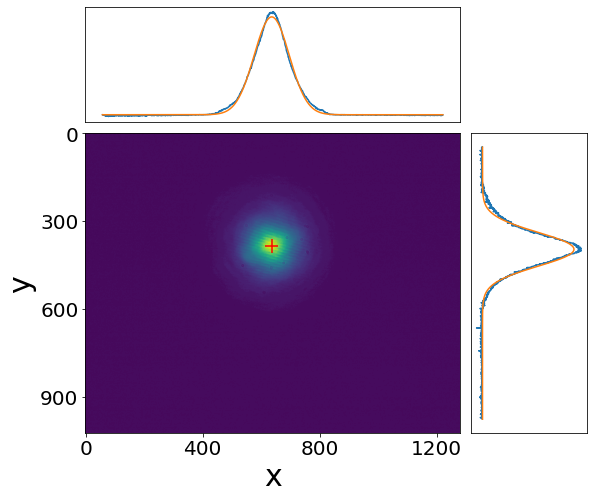

In [24]:
traditional(data)

## Problems:
    -- Hard to find the right model when there are multiple spots.
    -- It is hard to distinguish spots when they are close or overlap in x or y direction.
    -- It needs to be quick.

In [21]:
import cv2

x: 1014.9891337184683 y: 356.30835529934063


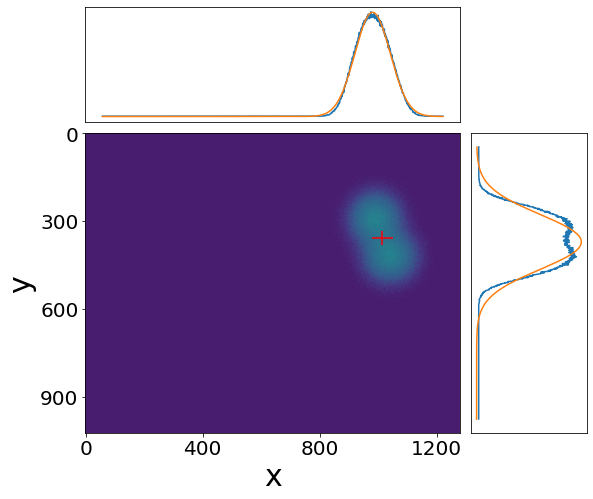

In [34]:
p1 = cv2.imread('p1.jpg')
p1 = cv2.cvtColor(p1,cv2.COLOR_BGR2RGB)
p1_out=np.sum(p1,axis=2)

traditional(p1_out)

x: 550.9793549442865 y: 544.6606549095914


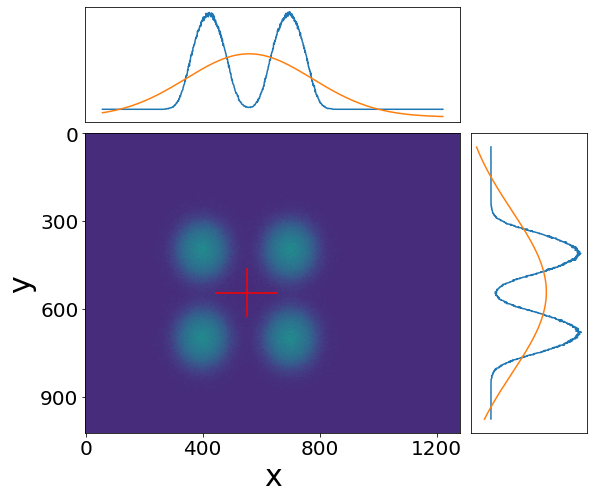

In [35]:
p2 = cv2.imread('p2.jpg')
p2 = cv2.cvtColor(p2,cv2.COLOR_BGR2RGB)
p2_out=np.sum(p2,axis=2)

traditional(p2_out)

x: 551.1067392749671 y: 544.8085565422192


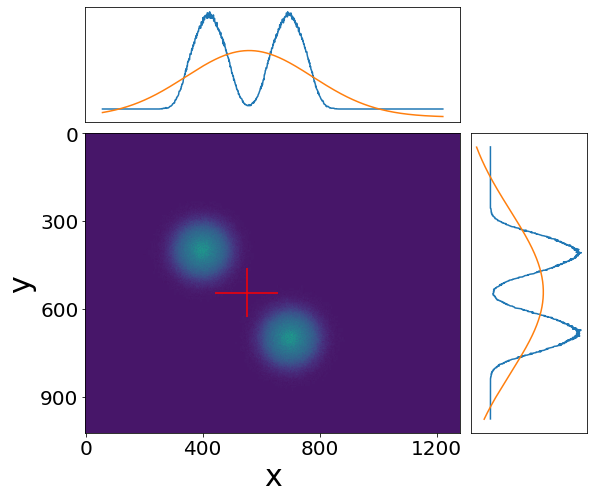

In [36]:
p3 = cv2.imread('p3.jpg')
p3 = cv2.cvtColor(p3,cv2.COLOR_BGR2RGB)
p3_out=np.sum(p3,axis=2)

traditional(p3_out)

## Solution:
    -- Meachine Learning
    
### Model
    -- MaskRCNN (Slow)
    -- Yolo (Quick)

### Step 1: Generate data

In [5]:
import scipy.misc
import random
import matplotlib.image
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:

file=open('data.txt','w+')
data_size=1
for num in range(data_size):

    number = int(random.random()*2)+1
    img=np.zeros((1024,1280))
    file.write('image_'+str(num).zfill(4)+'.jpg ')
    for each_point in range(number):

        x_c = int(random.random()*1280)
        y_c = int(random.random()*1024)

        x_err=int(random.random()*10-5)
        y_err=int(random.random()*10-5)

        int_err=int(random.random()*1000000-500000)

        x=norm.rvs(size=4000000+int_err,loc=x_c,scale=50+x_err)
        y=norm.rvs(size=4000000+int_err,loc=y_c,scale=50+y_err)

        for index in range(400000):
            x_i = int(x[index])
            y_i = int(y[index])
            if (x_i>0) & (x_i<1280) & (y_i>0) & (y_i<1024) :
                img[y_i][x_i]=img[y_i][x_i]+1

            xmin=max((x_c-50-abs(x_err)),0)
            ymin=max((y_c-50-abs(y_err)),0)
            xmax=min((x_c+50+abs(x_err)),1280)
            ymax=min((y_c+50+abs(y_err)),1024)

        file.write(str(xmin)+','+str(ymin)+','+str(xmax)+','+str(ymax)+',1 ')

    file.write('\n')
    matplotlib.image.imsave('image_'+str(num).zfill(4)+'.jpg',img)

file.close()

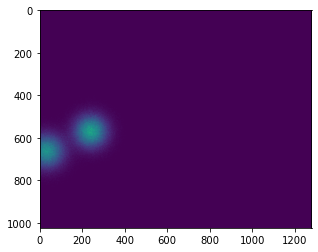

In [6]:
plt.imshow(img)

### Step2: Train model
### Step3: Apply model

In [40]:
import os
import shutil
import tensorflow as tf
import nmodel.core.utils as utils
from nmodel.core.config import cfg
from nmodel.core.yolov3 import YOLOv3,decode

In [47]:
def apply_model(filename):
    
    INPUT_SIZE=416
    NUM_CLASS=len(utils.read_class_names(cfg.YOLO.CLASSES))
    CLASSES=utils.read_class_names(cfg.YOLO.CLASSES)

    input_layer=tf.keras.layers.Input([INPUT_SIZE,INPUT_SIZE,3])
    feature_maps=YOLOv3(input_layer)

    bbox_tensors=[]
    for i,fm in enumerate(feature_maps):
        bbox_tensor=decode(fm,i)
        bbox_tensors.append(bbox_tensor)

    model=tf.keras.Model(input_layer,bbox_tensors)
    model.load_weights("./nmodel/yolov3")
    
    my_image=cv2.imread(filename+'.jpg')
    my_image=cv2.cvtColor(my_image,cv2.COLOR_BGR2RGB)
    image_size=my_image.shape[:2]
    
    image_data=utils.image_preporcess(np.copy(my_image),[INPUT_SIZE,INPUT_SIZE])
    image_data=image_data[np.newaxis, ...].astype(np.float32)

    pred_bbox=model.predict(image_data)
    pred_bbox=[tf.reshape(x,(-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox=tf.concat(pred_bbox,axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox,image_size,INPUT_SIZE,cfg.TEST.SCORE_THRESHOLD)
    bboxes = utils.nms(bboxes,cfg.TEST.IOU_THRESHOLD,method='nms')
    
    plt.imshow(my_image)
    for num in range(len(bboxes)):
        minx = bboxes[num][0]
        miny = bboxes[num][1]
        maxx = bboxes[num][2]
        maxy = bboxes[num][3]
        plt.plot([minx,maxx],[miny,miny],color='r')
        plt.plot([maxx,maxx],[miny,maxy],color='r')
        plt.plot([maxx,minx],[maxy,maxy],color='r')
        plt.plot([minx,minx],[maxy,miny],color='r')
        plt.plot((minx+maxx)/2,(miny+maxy)/2,'+',color='r')
        print ('center_x:',(minx+maxx)/2,'center_y:',(miny+maxy)/2)


center_x: 1039.0116271972656 center_y: 418.59954833984375
center_x: 987.4048767089844 center_y: 290.7503356933594


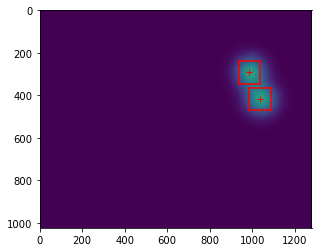

In [48]:
apply_model('p1')

### Step4: visualization

http://vinzzz.mynetgear.com/